# Cross-Validation of `k-NN` model

Make a k-fold cross-validation using natural years. _Leave-one-(natural year)-out_

In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openair))

suppressMessages(library(caret))
suppressMessages(library(BBmisc))

suppressMessages(library(gridExtra))

In [2]:
suppressMessages(library(doMC))
registerDoMC(cores=as.integer(detectCores()*0.75))

In [3]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [4]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

## Representative sample 

In [5]:
sites.lv <- c("es0118a", "es1438a") # Big cities (Madrid and Barcelona)",
sites.lv <- c(sites.lv, "es1580a", "es1340a") # small cities (Santander and Huelva)

save <- TRUE

## DataFrame Creation

In [6]:
# Create dataSet
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01")
                  ) %>%
            timeAverage(avg.time = "day", type=c("site", "variable"))
aq$date <- as_date(aq$date)

mto <- data_Mto %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01"))

df <- merge(aq, mto,
              by = c("date", "site"), all.x=T) %>%
        drop_na() %>%
        mutate_if(is.factor, as.character) %>%
        select(-date_end, -process, -summary, -validity, -atmos_pres)

rm(data_AQ)
rm(data_Mto)

## PreProcess

In [7]:
deseason <- function(cl) {
    # Remove seasonal component of the additive time serie.
    #     This function is called below by an apply
    
    dcomp <- decompose(ts(cl, frequency = 365))

    cl - dcomp$seasonal
}


filter.IQR <- function(dat, n, qntl=0.75) {
    
    min.IQ <- quantile(dat$value, 1-qntl)
    max.IQ <- quantile(dat$value, qntl)
    
    interval.IQR <- max.IQ - min.IQ
    
    dat[which(dat$value > (min.IQ - (n*interval.IQR)) &
              dat$value < (max.IQ + (n*interval.IQR))),]
}


range.df <- function(df, omit.cl) {
    # Scale dataframe ignoring no numeric columns (omit.cl)
    
    split.df <- df[, -omit.cl]
    
    cbind(df[, omit.cl],
          apply(X=split.df, MARGIN = 2, FUN = function(cl) {
              (cl - min(cl))/ (max(cl) - min(cl))
          })
         )
}

## Cross-Validation

In [8]:
leave.one.year.out <- function(yr, dat, omit.cl) { 
    # Do k-iteration of k-fold cv by pop yr data for test 
    #     and the rest for training
    # @params: omit.cl: columns to omit in the regression
    
    test <- which(year(dat$date) == yr)
    train <- which(year(dat$date) != yr)

    if(length(test) == 0) {
        return()
    } 
    if (length(train) == 0) {
        return()
    }        

    cv.k <- data.frame()
    
    for (k in c(1:15)) {
        model <- train(value ~., 
                       data=dat[, -omit.cl], subset=train,
                       method="knn",
                       tuneGrid=data.frame(k=k),
                       allowParallel = TRUE
                      )

    y.th <- predict(model, newdata=dat[test, -omit.cl])
    
    y.th.qq <- downscaleR:::eqm(dat[train,]$value, 
                                predict(model), 
                                y.th, 
                                n.quantile=99,
                                precip=FALSE, pr.threshold=0,
                                extrapolation="qwerty"
                               )
    
    if (sum(!is.na(dat$date)) > (365*2)) {
        # if there is enough data (more than 2 years), deseasonalized
        ds.dat <- cbind(dat[, omit.cl],
                     apply(dat[, -omit.cl], 2, deseason))
        ds.y.th <- predict(model, newdata=ds.dat[test,])
        
        ds.y.th.qq <- downscaleR:::eqm(dat[train,]$value, 
                                predict(model), 
                                ds.y.th, 
                                n.quantile=99,
                                precip=FALSE, pr.threshold=0,
                                extrapolation="qwerty"
                               )
        
        cor2 <- cor(ds.y.th, ds.dat[test,]$value)
        cor2.qq <- cor(ds.y.th.qq, ds.dat[test,]$value)
    } else {
        cor2 <- NaN 
        cor2.qq <- NaN
    }
    
    cv.k <- rbind(cv.k,
                  data.frame("year"=yr,
                             "k"=k,
                             "bias"=mean(y.th) / mean(dat[test,]$value),
                             "var.ratio"=var(y.th) / var(dat[test,]$value),
                             "cor1"=cor(y.th, dat[test,]$value),
                             "cor2"=cor2,
                             "RMSE"=sqrt(mean((y.th - dat[test,]$value)^2)),
                             ## q-q Mapping 
                             "bias.qq"=mean(y.th.qq) / mean(dat[test,]$value),
                             "var.ratio.qq"=var(y.th.qq) / var(dat[test,]$value),
                             "cor1.qq"=cor(y.th.qq, dat[test,]$value),
                             "cor2.qq"=cor2.qq,
                             "RMSE.qq"=sqrt(mean((y.th.qq - dat[test,]$value)^2))
                            ))
    }
    cv.k
}

In [9]:
years <- 2013:2019

no.num.cl <- 1:3 # no numeric columns 
cv.df <- data.frame()

# Create one model for each pair of station-pollutant
for (st in sites.lv) {
    data.st <- df[df$site == st,]
    
    for (pll in levels(as.factor(data.st$variable))) {
        print(paste(st, pll))
        dat <- data.st %>%
                filter(variable == pll) %>%
                range.df(no.num.cl)
        
        cv.row <- do.call(rbind, lapply(years, leave.one.year.out,
                                        dat, no.num.cl))

        cv.df <- rbind(cv.df,
                       cbind(data.frame("variable"=rep(pll, nrow(cv.row)),
                                        "site"=rep(st, nrow(cv.row))),
                             cv.row)
                       )
    }
}

[1] "es0118a no"
[1] "es0118a no2"
[1] "es0118a o3"
[1] "es0118a pm10"
[1] "es0118a pm2.5"
[1] "es1438a no"
[1] "es1438a no2"
[1] "es1438a o3"
[1] "es1580a no"
[1] "es1580a no2"
[1] "es1580a pm10"
[1] "es1340a no"
[1] "es1340a no2"
[1] "es1340a pm10"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


In [18]:
cv.df

variable,site,year,k,bias,var.ratio,cor1,cor2,RMSE,bias.qq,var.ratio.qq,cor1.qq,cor2.qq,RMSE.qq
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,es0118a,2013,1,0.9070707,0.8543887,0.6069653,0.1404671,0.08269408,0.9216445,0.8856607,0.6130307,0.1395690,0.08251168
no,es0118a,2013,2,0.9204212,0.7965977,0.6993541,0.1776475,0.07153933,0.9038698,0.8968257,0.7060318,0.1767315,0.07247398
no,es0118a,2013,3,0.9481224,0.7183559,0.7504433,0.2105984,0.06434956,0.9220134,0.8951739,0.7509033,0.2131980,0.06658548
no,es0118a,2013,4,0.9412949,0.6606006,0.7609787,0.2310306,0.06276647,0.9035487,0.8410785,0.7626146,0.2364096,0.06459034
no,es0118a,2013,5,0.9525391,0.6465954,0.7635320,0.2453398,0.06230547,0.9101089,0.8521338,0.7662606,0.2450010,0.06414659
no,es0118a,2013,6,0.9659651,0.6182891,0.7735718,0.2464492,0.06094949,0.9233071,0.8316816,0.7783419,0.2487850,0.06211342
no,es0118a,2013,7,0.9781659,0.6543463,0.7596638,0.2463028,0.06265196,0.9286024,0.8578582,0.7632306,0.2460164,0.06438168
no,es0118a,2013,8,0.9785474,0.6488842,0.7524331,0.2660420,0.06347837,0.9241720,0.8512660,0.7523090,0.2671631,0.06577875
no,es0118a,2013,9,0.9795151,0.6565750,0.7555281,0.2674558,0.06314844,0.9272689,0.8823016,0.7547226,0.2672508,0.06584252


In [10]:
mean.cv.df <- cv.df %>%
                group_by(variable) %>%
                summarise(bias=mean(bias, na.rm=T),
                          var.ratio=mean(var.ratio, na.rm=T),
                          cor1=mean(cor1, na.rm=T),
                          cor2=mean(cor2, na.rm=T),
                          RMSE=mean(RMSE, na.rm=T),
                          ## q-q Mapping
                          bias.qq=mean(bias.qq, na.rm=T),
                          var.ratio.qq=mean(var.ratio.qq, na.rm=T),
                          cor1.qq=mean(cor1.qq, na.rm=T),
                          cor2.qq=mean(cor2.qq, na.rm=T),
                          RMSE.qq=mean(RMSE.qq, na.rm=T)
                         ) %>%
                print()

# A tibble: 5 x 11
  variable  bias var.ratio  cor1  cor2   RMSE bias.qq var.ratio.qq cor1.qq
* <chr>    <dbl>     <dbl> <dbl> <dbl>  <dbl>   <dbl>        <dbl>   <dbl>
1 no       1.01      0.549 0.586 0.257 0.0836   0.989        0.842   0.585
2 no2      1.01      0.542 0.567 0.382 0.118    1.01         0.997   0.563
3 o3       0.999     0.779 0.799 0.378 0.120    1.00         0.988   0.793
4 pm10     1.00      0.561 0.411 0.243 0.0756   0.984        0.809   0.421
5 pm2.5    1.01      0.571 0.553 0.309 0.0628   0.988        0.930   0.543
# … with 2 more variables: cor2.qq <dbl>, RMSE.qq <dbl>


In [35]:
pivot.cv.df.qq <- cv.df %>%
        pivot_longer(cols = 9:13,
                     names_to = "Error", values_to = "Err.Val")

plt.qq <- ggplot(data=pivot.cv.df.qq, aes(x=Error, y=Err.Val, fill=Error)) +
            geom_boxplot() +
            ggtitle("q-q Mapping") +
            theme(plot.title = element_text(hjust = 0.5)) + 
            theme(legend.position = "none") + 
            facet_wrap(~variable, scale="free")

In [36]:
pivot.cv.df <- cv.df %>%
        pivot_longer(cols = 5:9, 
                     names_to = "Error", values_to = "Err.Val")

pivot.cv.df <- pivot.cv.df[-which(pivot.cv.df$Err.Val > 8), ]

plt <- ggplot(data=pivot.cv.df, aes(x=Error, y=Err.Val, fill=Error)) +
            geom_boxplot() +
            ggtitle("Without q-q Mapping") +
            theme(plot.title = element_text(hjust = 0.5)) + 
            theme(legend.position = "none") + 
            facet_wrap(~variable, scale="free")

Warning message:
“Removed 30 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 30 rows containing non-finite values (stat_boxplot).”


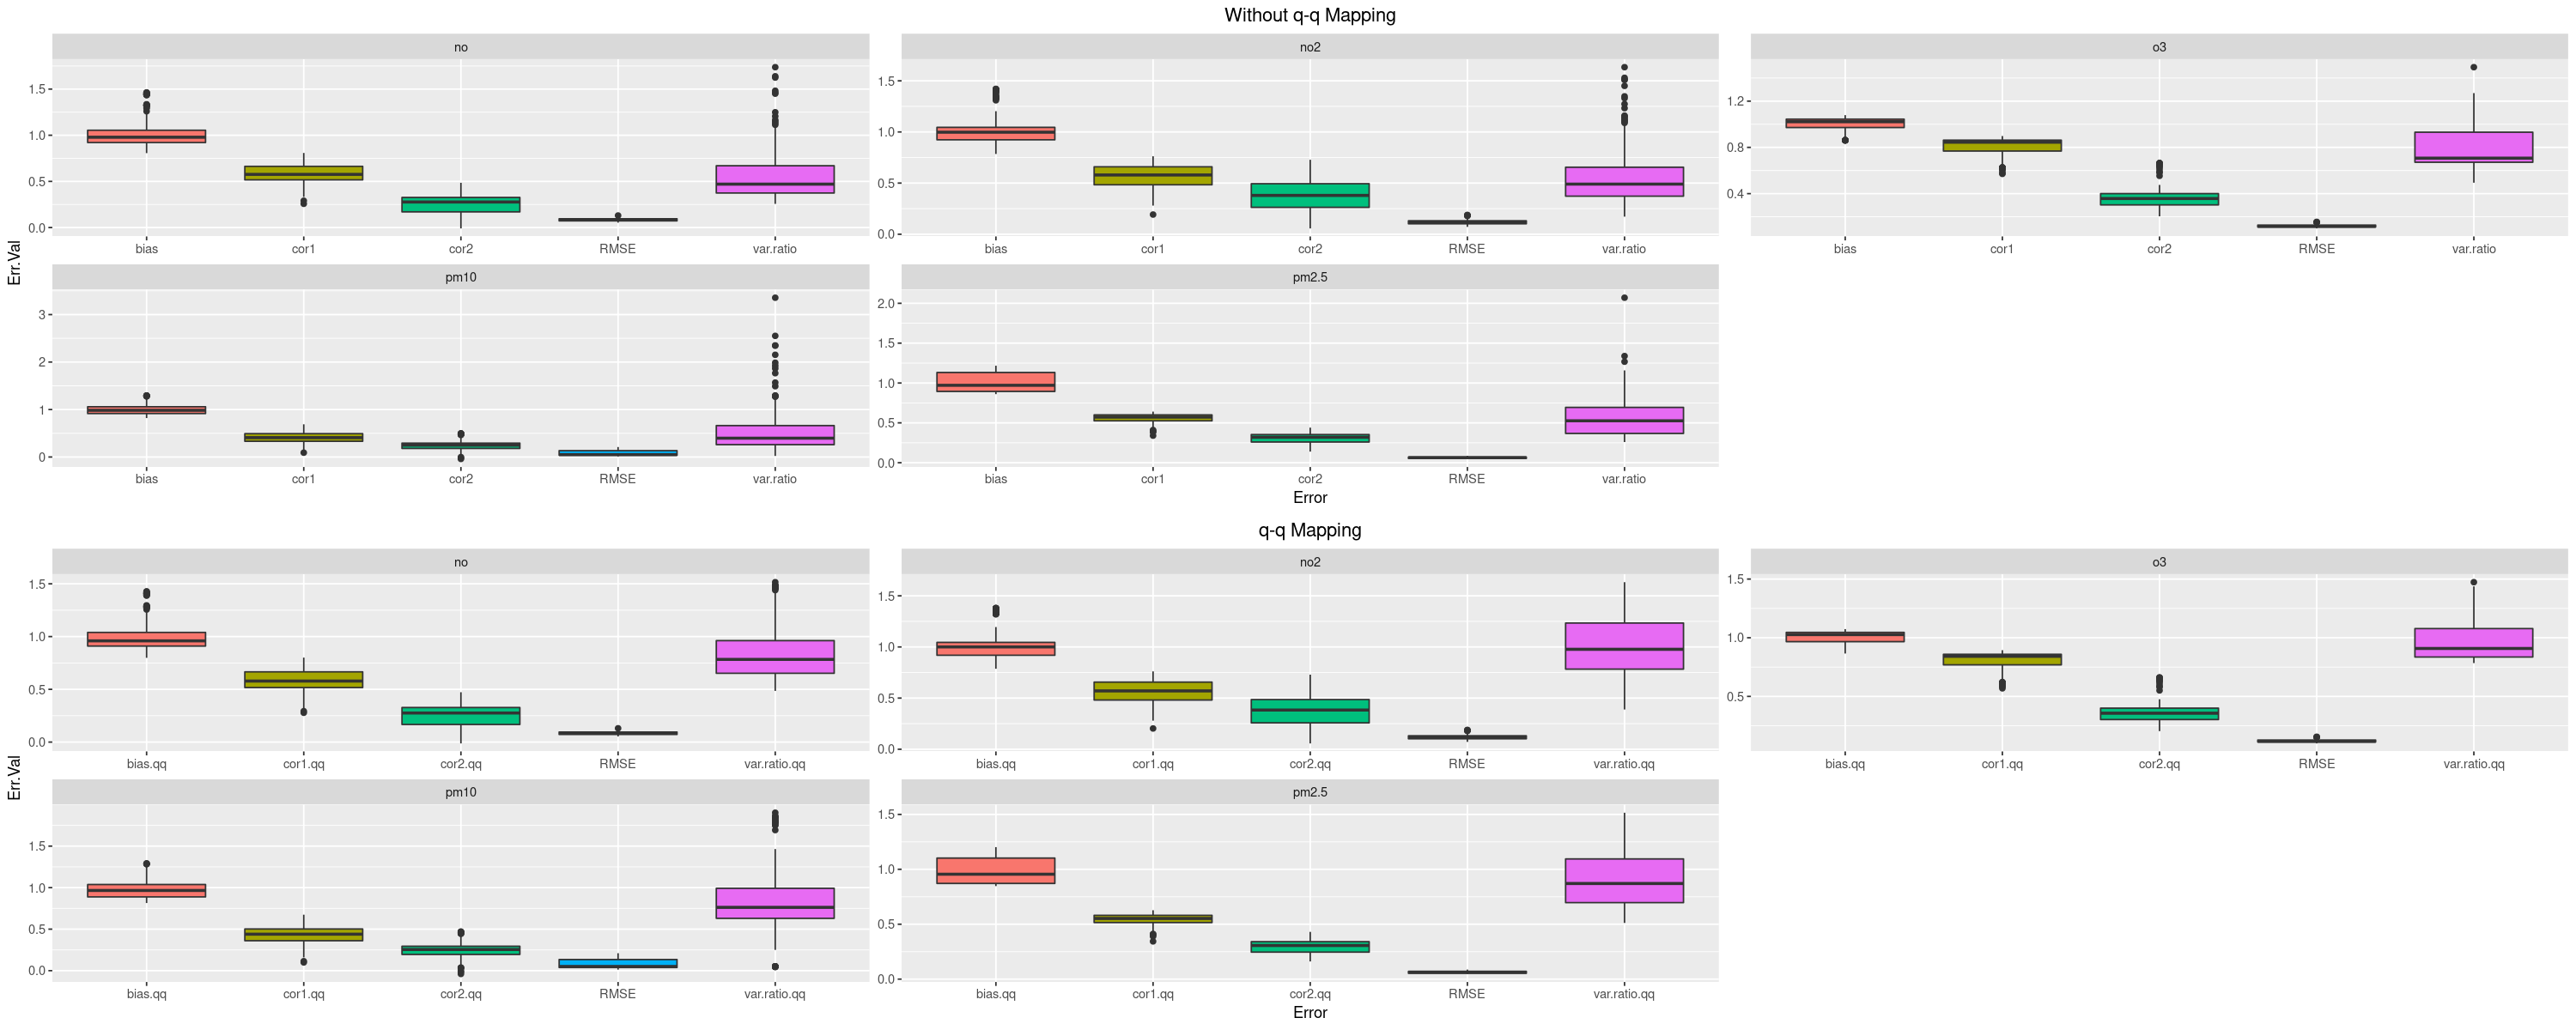

In [37]:
all.plt <- grid.arrange(plt, plt.qq, nrow=2)

# Save Results

In [38]:
if (save ==TRUE) {
    write.csv(cv.df, "data/Cross-validation/knn-qq-mapping.csv", row.names=F)

    ggsave(
        "knn-CV-qq-mapping.png",
        plot = all.plt,
        device = "png",
        path = "Plots/cross-validation/knn/",
        width=10,
        height=15
    )
}